In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation

In [3]:
def nice_plot_nodes(ax):
    ax.set(xticks=[], yticks=[])

def plot_graph(ax, graph, s=1000):
    xmin = float(torch.min(graph.pos[:,0]))
    xmax = float(torch.max(graph.pos[:,0]))
    ymin = float(torch.min(graph.pos[:,1]))
    ymax = float(torch.max(graph.pos[:,1]))
    ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1))

    # Plot the nodes:
    for idx, pos in enumerate(graph.pos):
        ax.scatter(*pos.T, c='C1', s=s, edgecolors='black')
        ax.text(*pos.T, f'{idx}', color='w', ha='center', va='center')    
    
    # Plot the edges:
    for idx, (i1,i2) in enumerate(graph.edge_index.T):
        ax.plot([graph.pos[i1,0], graph.pos[i2,0]], [graph.pos[i1,1], graph.pos[i2,1]], c='black', zorder=0)
    
    

### 5.1 Graphs
This exercise is about setting up some graphs and getting accustomed to manipulate them. There will be no messages sent, and no trainable parameters on the graphs in this exercise.

### 5.2 Some graphs
This helper function provides you with edge indices, random node positions, and node values for graphs with all nodes interconnected to each other. `num_nodes` is the number of nodes in the graph.

In [4]:
def elements_for_random_graph(num_nodes):
    cutoff = 2.5

    box_size=10
    positions = []
    for i in range(num_nodes):
        new_position = torch.rand(1, 2) * box_size
        if len(positions) > 0:
            all_positions = torch.vstack(positions)
            while torch.any(torch.cdist(all_positions, new_position) < 0.75*cutoff) or \
            torch.all(torch.cdist(all_positions, new_position) > cutoff):
                new_position = torch.rand(1, 2) * box_size        
        positions.append(new_position)

    positions = torch.vstack(positions)

    edge_index = []
    for i in range(len(positions)):
        for j in range(len(positions)):
            edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    x = torch.tensor(list(range(num_nodes)),dtype=torch.float32)
    return edge_index, positions, x

a) Call `elements_for_random_graph` for a 4-node graph to get something like:

In [5]:
torch.manual_seed(0)
elements_for_random_graph(4)

(tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]),
 tensor([[4.9626, 7.6822],
         [3.0742, 6.3408],
         [3.4889, 4.0172],
         [6.9767, 8.0001]]),
 tensor([0., 1., 2., 3.]))

C:\Users\Jakob\AppData\Local\Temp\ipykernel_27892\2985054981.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  ax.scatter(*pos.T, c='C1', s=s, edgecolors='black')


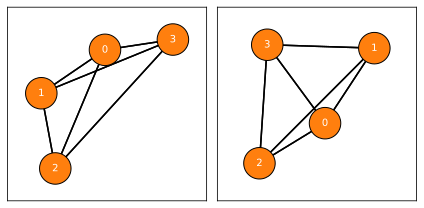

In [6]:
torch.manual_seed(0)
edge_index1, positions1, x1 = elements_for_random_graph(4)
edge_index2, positions2, x2 = elements_for_random_graph(4)
graph1 = Data(x=x1, edge_index=edge_index1, pos=positions1)
graph2 = Data(x=x2, edge_index=edge_index2, pos=positions2)
list_of_graphs = [graph1, graph2]

fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, graph in zip(axes, list_of_graphs):
    plot_graph(ax, graph)
    nice_plot_nodes(ax)
plt.tight_layout()

fig.savefig('ex59_fig1.png')

### 5.3 Similarity of graphs

d) Write a function that will tell if two graphs are most likely identical according to the sorted eigenvalues of the adjacency matrix. Check if `graph1` and `graph2` are identical.

In [7]:
def is_identical_graphs(graph1, graph2, atol=1e-5):
    # Collect all the eigenvalues for each graph in the list
    list_of_graphs = [graph1, graph2]
    eigenvalue_tensors = []
    for graph in list_of_graphs:
        adj_matrix = to_dense_adj(graph.edge_index)
        eigenvalues = torch.linalg.eigvalsh(adj_matrix)
        eigenvalues = torch.sort(eigenvalues).values
        eigenvalue_tensors.append(eigenvalues)
    
    eigenvalue_tensors = torch.vstack(eigenvalue_tensors)

    # Check if all the eigenvalues are the same
    return torch.allclose(eigenvalue_tensors[0], eigenvalue_tensors[1], atol=atol)

is_identical_graphs(*list_of_graphs, atol=1e-5)

True

e) Write a function that receives the `edge_index` and `positions` that you get from `elements_for_random_graph` and returns a new `edge_index` that only contains indices for edges that are shorter than 2.5.

In [8]:
def keep_short_edges(edge_index, positions):
    edge_index_to_keep = []
    for edge in edge_index.T:
        source = positions[edge[0]]
        target = positions[edge[1]]
        if torch.linalg.norm(source - target) < 2.5:
            edge_index_to_keep.append(edge)
    edge_index_to_keep = torch.tensor(np.array(edge_index_to_keep).T)
    return edge_index_to_keep

print(f'Original edge index:\n{edge_index1}', end='\n\n')
print(f'Sorted edge index:\n{keep_short_edges(edge_index1, positions1)}')

Original edge index:
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

Sorted edge index:
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3],
        [0, 1, 3, 0, 1, 2, 1, 2, 0, 3]])


f) Make a function that first calls `elements_for_random_graph`, and then calls your function from e), and finally returns a Torch Geometric graph object, where now only edges shorter than 2.5 are retained.

In [9]:
def random_graph(num_nodes):
    edge_index, positions, x = elements_for_random_graph(num_nodes)
    edge_index = keep_short_edges(edge_index, positions)
    graph = Data(x=x, edge_index=edge_index, pos=positions)
    return graph

g) Call `random_graph` twice and plot the two graphs.

h) Check if the two graphs are identical according to the criterion involving the sorted eigenvalue spectra.

Are the graphs identical? False


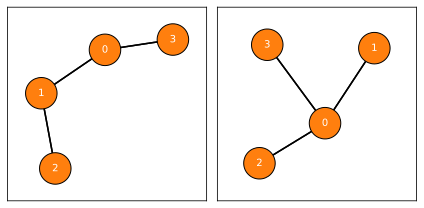

In [10]:
torch.manual_seed(0)
list_of_graphs = [random_graph(4) for _ in range(2)]

fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, graph in zip(axes, list_of_graphs):
    plot_graph(ax, graph)
    nice_plot_nodes(ax)
plt.tight_layout()

print(f'Are the graphs identical? {is_identical_graphs(*list_of_graphs)}')

fig.savefig('ex59_fig2.png')

i) Create very many random graphs with 5 nodes. Keep those with unique graphs in a list. Plot the graphs eventually. Now many distinct graphs can you find?

In [11]:
def random_graphs(num_graphs, num_nodes, patience=1000):
    graph0 = random_graph(num_nodes)
    list_of_graphs = [graph0]

    attempts = 0
    while len(list_of_graphs) < num_graphs and attempts < patience:
        proposed_graph = random_graph(num_nodes)
        
        # Check if the proposed graph's eigenvalues are identical to any in the list
        identical_graphs = False
        for graph in list_of_graphs:
            if is_identical_graphs(proposed_graph, graph):  # Uses sorted eigenvalues
                identical_graphs = True
                break  # No need to check further

        # Append the graph if it has unique eigenvalues
        if not identical_graphs:
            list_of_graphs.append(proposed_graph)
            attempts = 0  # Reset attempts on success
        else:
            attempts += 1  # Increment attempts if graph is not added

    return list_of_graphs

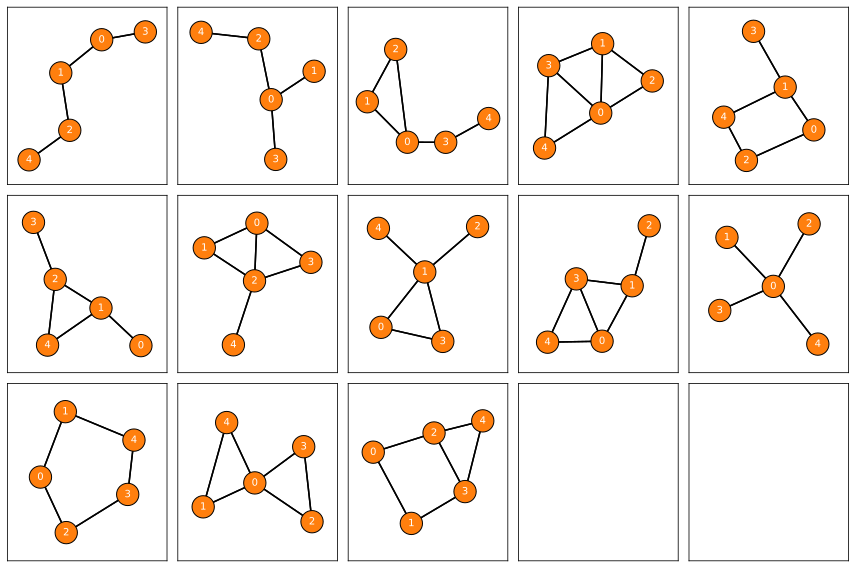

In [12]:
torch.manual_seed(0)
list_of_graphs = random_graphs(15, 5)

fig, axes = plt.subplots(3, 5, figsize=(12,8))
for ax, graph in zip(axes.flatten(), list_of_graphs):
    plot_graph(ax, graph, s=500)
for ax in axes.flatten():
    nice_plot_nodes(ax)
plt.tight_layout()

fig.savefig('ex59_fig3.png')

Til portføljen: jeg havde ladet den absolutte tolerance være uændret i `torch.allclose()`, standard er 10^-8. Nogle egenværdier var 0, andre var 10^-7 for identiske grafer, hvilket gav en fejl.